## CSC 380 Final Project
Authors: Emma Elliott, Bronson Housmans
## Overview
This project will create decision trees for several datasets, where each node is a SVM model (linear or nonlinear kernel), and each leaf is a class. We used a Gini index to evaluates the effectiveness of a given model. Each dataset is plotted along with its decision boundaries.  

In [45]:
import numpy as np
import sys
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from itertools import combinations 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
from numpy import meshgrid
import itertools
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report

In [46]:
# initializing some values below
X_train = Y_train = X_test = Y_test = None

In [47]:
def getData(train_data, test_data):
    """
    This function gets the test and train data from the input string in the form
    "./data/DataXTrain.csv"

    Args:
        train_data (string): A string for the training csv of the specified number
        test_data (string): A string for the test csv of the specified number

    Returns:
        X1_train (pandas df): A dataframe of the x and y values of the training csv
        Y1_train (pandas df): A dataframe of the class values of the training csv
        X1_test (pandas df): A dataframe of the x and y values of the test csv
        Y1_test (pandas df): A dataframe of the class values of the test csv
    """
    X1_df = pd.read_csv(train_data)
    X1T_df = pd.read_csv(test_data)

    X1_train = X1_df[['x', 'y']]
    Y1_train = X1_df[['Class']]
    X1_test = X1T_df[['x', 'y']]
    Y1_test = X1T_df[['Class']]

    return X1_train, Y1_train, X1_test, Y1_test

In [48]:
class Node:
    """
    A class for the Node object that will store the data for the tree

    Attributes:
        model: The best selected SVC for the training data
        isLeaf: Boolean value for if the node is a leaf or not
        Left: The Node to the left of self
        Right: The Node to the right of self
    """
    def __init__(self, model):
        # initializes default values for the Node object
        self.model = model
        self.isLeaf = True
        self.Left = None
        self.Right = None

    def setModel(self, model_in):
        # sets the Node model to the input model
        self.model = model_in

    def setRight(self, node_in):
        # sets the Right child of self with the input Node
        self.Right = node_in
        self.isLeaf = False

    def setLeft(self, node_in):
        # sets the Left child of self with the input Node
        self.Left = node_in
        self.isLeaf = False

    def is_leaf(self):
        # returns the isLeaf boolean attribute
        return self.isLeaf
    
    def get_model(self):
        # returns the Node's SVC model
        return self.model

    def print_tree(self):
        # testing only
        print(self.isLeaf)
        print(self.Right.isLeaf)
        print(self.Left.isLeaf)

In [49]:
def gini_index_one(X_train, Y_train, class_label_one, model):
    """
    This function calculates the Gini index for the case where there is one 
    class that is being separated from the rest

    Args:
        X_train (pandas df): The training data for x and y values
        Y_train (pandas df): The training data for the class values
        class_label_one (int): The class that is being separated
        model (SVC): The model selected from training

    Returns:
        gini index value and direction to branch (below = left, above = right)
    """
    class_label_one = int(class_label_one)
    w = model.coef_[0]
    b = model.intercept_[0]
    merged = X_train.join(Y_train)
    filter_points = merged[merged['Class'] == class_label_one]
    # needs to be checked because vertical line has undefined slope
    if w[1] == 0:
        vertical_line = -b / w[0]
        left = 0
        right = 0
        # determine if the majority of the x values are left or right of vertical line
        for x in filter_points['x']:
            if x < vertical_line:
                left += 1
            else:
                right += 1
        # scoring for Gini index for fractions of data that are correct/incorrect
        left_correct = 0
        left_wrong= 0
        right_correct= 0
        right_wrong = 0
        if left > right:
            # label is correct if the x value is left of vertical line
            # the rest of the labels should be right of the line to be correct
            for x, val in zip(merged['x'], merged['Class']):
                if x < vertical_line:
                    if val == class_label_one:
                        left_correct += 1
                    else:
                        left_wrong += 1
                else:
                    if val == class_label_one:
                        right_wrong += 1
                    else:
                        right_correct += 1
            # calcluate the Gini values for the potential subtrees left and right
            left_gini = 1 - (left_correct/(left_correct+left_wrong))**2 - (left_wrong/(left_correct+left_wrong))**2
            right_gini = 1 - (right_correct/(right_correct+right_wrong))**2 - (right_wrong/(right_correct+right_wrong))**2
            # calcualte the Gini index overall and return the direction to branch
            return (left_correct+left_wrong)/len(merged['x']) * left_gini + (right_correct+right_wrong)/len(merged['x']) * right_gini, "below"
        else:
            # want the x values of the selected label to be right of the vertical line
            for x, val in zip(merged['x'], merged['Class']):
                if x < vertical_line:
                    if val == class_label_one:
                        left_wrong += 1
                    else:
                        left_correct += 1
                else:
                    if val == class_label_one:
                        right_correct += 1
                    else:
                        right_wrong += 1
            # calcluate the Gini values for the potential subtrees left and right            
            left_gini = 1 - (left_correct/(left_correct+left_wrong))**2 - (left_wrong/(left_correct+left_wrong))**2
            right_gini = 1 - (right_correct/(right_correct+right_wrong))**2 - (right_wrong/(right_correct+right_wrong))**2
            # calcualte the Gini index overall and return the direction to branch
            return (left_correct+left_wrong)/len(merged['x']) * left_gini + (right_correct+right_wrong)/len(merged['x']) * right_gini, "above"
    else: 
        # calculate the slope and intercept from the model for form y = mx+b
        slope = -w[0] / w[1]
        intercept = -b / w[1]
        above = 0
        below = 0
        # determine if majority of points of class are above/below line
        for x,y in zip(filter_points['x'], filter_points['y']):
            if y < slope * x + intercept:
                below += 1
            else:
                above += 1
        above_correct = 0
        above_wrong = 0
        below_correct = 0
        below_wrong = 0
        if above >= below:
            # want the label points above line, others to be below
            for x, y, val in zip(merged['x'], merged['y'], merged['Class']):
                if y >= slope * x + intercept:
                    if val == class_label_one:
                        above_correct += 1
                    else:
                        above_wrong += 1
                else:
                    if val == class_label_one:
                        below_wrong += 1
                    else:
                        below_correct += 1
            # calculate gini for points above/below line given by model
            above_gini = 1 - (above_correct/(above_correct+above_wrong))**2 - (above_wrong/(above_correct+above_wrong))**2
            below_gini = 1 - (below_correct/(below_correct+below_wrong))**2 - (below_wrong/(below_correct+below_wrong))**2
            # return the calculated Gini index from above/below and the direction to branch selected class
            return (above_correct+above_wrong)/len(merged['x']) * above_gini + (below_correct+below_wrong)/len(merged['x']) * below_gini, "above"
        else:
            above_correct = 0
            above_wrong = 0
            below_correct = 0
            below_wrong = 0
            # want the current class to be below line, others to be above
            for x, y, val in zip(merged['x'], merged['y'], merged['Class']):
                if y >= slope * x + intercept:
                    if val == class_label_one:
                        above_wrong += 1
                    else:
                        above_correct += 1
                else:
                    if val == class_label_one:
                        below_correct += 1
                    else:
                        below_wrong += 1
                above_gini = 1
                if (above_correct+above_wrong) != 0:
                    above_gini = 1 - (above_correct/(above_correct+above_wrong))**2 - (above_wrong/(above_correct+above_wrong))**2
                below_gini = 1
                if (below_correct+below_wrong) != 0:
                    below_gini = 1 - (below_correct/(below_correct+below_wrong))**2 - (below_wrong/(below_correct+below_wrong))**2
                return (above_correct+above_wrong)/len(merged['x']) * above_gini + (below_correct+below_wrong)/len(merged['x']) * below_gini, "below"
            
def gini_index_two(X_train, Y_train, class_label_one, class_label_two, model):
    """
    This function calculates the Gini index for the case where there is one 
    class that is being separated from the rest

    Args:
        X_train (pandas df): The training data for x and y values
        Y_train (pandas df): The training data for the class values
        class_label_one (int): The class that is being separated
        model (SVC): The model selected from training

    Returns:
        gini index value and direction to branch (below = left, above = right)
    
    NOTE: See the inline comments for gini_index_one as they represent same functionality,
    just for the boundary of one class instead of two
    """
    class_label_one = int(class_label_one)
    class_label_two = int(class_label_two)
    selected = [class_label_one, class_label_two]
    w = model.coef_[0]
    b = model.intercept_[0]
    merged = X_train.join(Y_train)
    filter_points = merged[merged['Class'].isin(selected)]
    
    if w[1] == 0:
        vertical_line = -b / w[0]
        left = 0
        right = 0
        for x in filter_points['x']:
            if x < vertical_line:
                left += 1
            else:
                right += 1
        left_correct = 0
        left_wrong = 0
        right_correct = 0
        right_wrong = 0
        if left > right:
            for x, val in zip(merged['x'], merged['Class']):
                if x < vertical_line:
                    if val == class_label_one or val == class_label_two:
                        left_correct += 1
                    else:
                        left_wrong += 1
                else:
                    if val == class_label_one or val == class_label_two:
                        right_wrong += 1
                    else:
                        right_correct += 1
            left_gini = 1 - (left_correct/(left_correct+left_wrong))**2 - (left_wrong/(left_correct+left_wrong))**2
            right_gini = 1 - (right_correct/(right_correct+right_wrong))**2 - (right_wrong/(right_correct+right_wrong))**2
            return (left_correct+left_wrong)/len(merged['x']) * left_gini + (right_correct+right_wrong)/len(merged['x']) * right_gini, "below"
        else:
            for x, val in zip(merged['x'], merged['Class']):
                if x < vertical_line:
                    if val == class_label_one or val == class_label_two:
                        left_wrong += 1
                    else:
                        left_correct += 1
                else:
                    if val == class_label_one or val == class_label_two:
                        right_correct += 1
                    else:
                        right_wrong += 1
            left_gini = 1 - (left_correct/(left_correct+left_wrong))**2 - (left_wrong/(left_correct+left_wrong))**2
            right_gini = 1 - (right_correct/(right_correct+right_wrong))**2 - (right_wrong/(right_correct+right_wrong))**2
            return (left_correct+left_wrong)/len(merged['x']) * left_gini + (right_correct+right_wrong)/len(merged['x']) * right_gini, "above"
    else:
        slope = -w[0] / w[1]
        intercept = -b / w[1]
        above = 0
        below = 0
        for x,y in zip(filter_points['x'], filter_points['y']):
            if y < slope * x + intercept:
                below += 1
            else:
                above += 1
        above_correct = 0
        above_wrong = 0
        below_correct = 0
        below_wrong = 0
        if above >= below:
            for x, y, val in zip(merged['x'], merged['y'], merged['Class']):
                if y >= slope * x + intercept:
                    if val == class_label_one or val == class_label_two:
                        above_correct += 1
                    else:
                        above_wrong += 1
                else:
                    if val == class_label_one or val == class_label_two:
                        below_wrong += 1
                    else:
                        below_correct += 1
            above_gini = 1
            if (above_correct+above_wrong) != 0:
                above_gini = 1 - (above_correct/(above_correct+above_wrong))**2 - (above_wrong/(above_correct+above_wrong))**2
            below_gini = 1
            if (below_correct+below_wrong) != 0:
                below_gini = 1 - (below_correct/(below_correct+below_wrong))**2 - (below_wrong/(below_correct+below_wrong))**2
            return (above_correct+above_wrong)/len(merged['x']) * above_gini + (below_correct+below_wrong)/len(merged['x']) * below_gini, "above"
        else:
            above_correct = 0
            above_wrong = 0
            below_correct = 0
            below_wrong = 0
            for x, y, val in zip(merged['x'], merged['y'], merged['Class']):
                if y >= slope * x + intercept:
                    if val == class_label_one:
                        above_wrong += 1
                    else:
                        above_correct += 1
                else:
                    if val == class_label_one:
                        below_correct += 1
                    else:
                        below_wrong += 1
                above_gini = 1
                if (above_correct+above_wrong) != 0:
                    above_gini = 1 - (above_correct/(above_correct+above_wrong))**2 - (above_wrong/(above_correct+above_wrong))**2
                below_gini = 1
                if (below_correct+below_wrong) != 0:
                    below_gini = 1 - (below_correct/(below_correct+below_wrong))**2 - (below_wrong/(below_correct+below_wrong))**2
                return (above_correct+above_wrong)/len(merged['x']) * above_gini + (below_correct+below_wrong)/len(merged['x']) * below_gini, "below"

In [50]:
def separate_one(X_train, Y_train, is_not_linear, class_label_one):
    """ 
    This function creates a SVC model to create a boundary between one class
    and the rest

    Args:
        X_train (pandas df): The training data for x and y values
        Y_train (pandas df): The training data for the class values
        is_not_linear (boolean): determines which kernal of SVC to use
        class_label_one (int): The class selected to create boundary around

    Returns:
        model (SVC): The SVC model used to create the boundary
        acc (float): The Gini index
        direction (string): Which direction to branch the data
    """
    Y_bin = np.isin(Y_train, [class_label_one]).astype(int)
    Y_bin = Y_bin.ravel()
    model = SVC(kernel='linear', degree=1)
    if is_not_linear:
        model = SVC(kernel='rbf', degree = 3)
    #print(Y_bin)
    model.fit(X_train, Y_bin)
    #print(model.coef_)
    if is_not_linear:
        # determine if more points in the class are above or below the decision boundary
        # get rbf function, determine where x vals lie
        model.decision_function(X_train)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        acc_report = classification_report(Y_test['Class'], Y_pred)
        # accuracy determined from classifcation report
        acc = float(list(acc_report.split())[5])
        direction = random.choice(['above', 'below'])
            
    else:
        acc, direction = gini_index_one(X_train, Y_train, class_label_one, model)
    return model, acc, direction

def separate_two(X_train, Y_train, is_not_linear, class_label_one, class_label_two):
    """ 
    This function creates a SVC model to create a boundary between two classes
    and the rest

    Args:
        X_train (pandas df): The training data for x and y values
        Y_train (pandas df): The training data for the class values
        is_not_linear (boolean): determines which kernal of SVC to use
        class_label_one (int): The first class selected to create boundary around
        class_label_two (int): The second class selected to create boundary around

    Returns:
        model (SVC): The SVC model used to create the boundary
        acc (float): The Gini index
        direction (string): Which direction to branch the data
    """
    Y_bin = np.isin(Y_train, [class_label_one, class_label_two]).astype(int)
    Y_bin = Y_bin.ravel()
    model = SVC(kernel='linear', degree=1)
    if is_not_linear:
        model = SVC(kernel='rbf', degree = 3)
    #print(Y_bin)
    model.fit(X_train, Y_bin)
    if is_not_linear:
        model.decision_function(X_train)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        # accuracy of non linear model determined from classifcation report
        acc_report = classification_report(Y_test['Class'], Y_pred)
        acc = float(list(acc_report.split())[5])
        direction = random.choice(['above', 'below'])
    else:
        acc, direction = gini_index_two(X_train, Y_train, class_label_one, class_label_two, model)
    #print(model.coef_)
    return model, acc, direction

In [51]:
def classify_point(curr, x_in, y_in, isLin):
    '''
    This function takes a model and an (x,y) coordinate, and determines
    which class it belongs to based on the model

    Args:
        curr (Node): the root of the tree containing SVM objects
        x_in, y_in (float): Coordinate values to classify
        isLin (bool): True if linear kernel is used
    
    Return:
        A class (1-4) that was predicted based on SVM model
    '''
    if not isLin:
        # returns classifcation prediction if model is non linear
        return curr.model.predict(np.array([x_in, y_in]).reshape(1, -1))[0]
    while not curr.is_leaf():
        # finds slope/intercept params for linear kernel and 
        # finds where (x,y) lie around the line
        w = curr.model.coef_[0]
        b = curr.model.intercept_[0]
        if w[1] == 0:
            vertical_line = -b / w[0]
            if x_in < vertical_line:
                curr = curr.Left
            else:
                curr = curr.Right
        else:
            slope = -w[0] / w[1]
            intercept = -b / w[1]
            if y_in < slope * x_in + intercept:
                curr = curr.Left
            else:
                curr = curr.Right
    return curr.model

def score_accuracy(root, X_test, Y_test, isLin):
    '''
    This function will score the accuracy of the current model
    with the testing data 

    Args:
        root (Node): the root of the tree containing SVM objects
        X_test, Y_test (pd Dataframe): Testing data for the associated training data
        isLin (bool): True if linear kernel is used
    '''
    score = 0
    tups = zip(X_test['x'].values, X_test['y'].values)
    iter = 0
    n = len(Y_test['Class'].values)
    for x,y in tups:
        classification = classify_point(root, x, y, isLin)
        if (classification == Y_test['Class'].values[iter]):
            score += 1
        iter += 1
    return score / n

def get_models(curr, model_arr):
    # helper function for plotting models
    if curr is None:
        return
    if not curr.is_leaf():
        model_arr.append(curr.model)
    get_models(curr.Left, model_arr)
    get_models(curr.Right, model_arr)

In [52]:
def build_tree(curr, classes, X_train, Y_train, isLin):
    """ 
    This function recursively builds the tree that contains the models as inner nodes and the
    classes as the leaves

    Args:
        curr (Node): The current Node for data to be placed in
        classes: The classes to be used for creating boundaries
        X_train (pandas df): The training data for x and y values
        Y_train (pandas df): The training data for the class values
    """
    class_pairs = list(itertools.combinations(classes, 2))
    best_model = None
    best_acc = 1.0
    best_dir = ""
    left_split = []
    right_split = []
    for val in classes:
        curr_model, curr_acc, curr_dir = separate_one(X_train, Y_train, not isLin, val)
        if curr_acc <= best_acc:
            best_model = curr_model
            best_acc = curr_acc
            best_dir = curr_dir
        # sort the classes and determine how to branch them for the subtree
        if best_dir == "below":
            left_split = np.array([val])
            right_split = classes[classes != val]
        else:
            right_split = np.array([val])
            left_split = classes[classes != val]
        if len(class_pairs) > 2:
            for class_label_one, class_label_two in class_pairs:
                curr_model, curr_acc, curr_direction = separate_two(X_train, Y_train, not isLin, class_label_one, class_label_two)
                if curr_acc <= best_acc:
                    best_model = curr_model
                    best_acc = curr_acc
                    best_direction = curr_direction
                    val_arr = [class_label_one, class_label_two]
                    if best_direction == "below":
                        left_split = np.array(val_arr)
                        right_split = classes[~np.isin(classes, val_arr)]
                    else:
                        right_split = np.array(val_arr)
                        left_split = classes[~np.isin(classes, val_arr)]
        # case when we are down to 0 or 1 values to be split for both sides of tree
        if len(left_split) < 2 and len(right_split) < 2:
            curr.setModel(best_model)
            if len(left_split) > 0:
                curr.setLeft(Node(left_split[0]))
            else:
                # since we have a binary tree, one leaf is ignored when one value was remaining
                curr.setLeft(Node("ignore"))
            if len(right_split) > 0:
                curr.setRight(Node(right_split[0]))
            else:
                curr.setRight("ignore")
            return
        elif len(left_split) < 2:
            curr.setModel(best_model)
            if len(left_split) > 0:
                curr.setLeft(Node(left_split[0]))
            else:
                curr.setLeft(Node("ignore"))
            # we still need to build out right subtree since more than two nodes remain
            # to be separated with boundaries
            merged = X_train.join(Y_train)
            filter_right = merged[merged['Class'].isin(right_split)]
            X_train_right = filter_right[['x', 'y']]
            Y_train_right = filter_right[['Class']]
            curr.setRight(Node(None))
            build_tree(curr.Right, right_split, X_train_right, Y_train_right, isLin)
        # case when right side of tree is down to 0 or 1 values to be split
        elif len(right_split) < 2:
            curr.setModel(best_model)
            if len(right_split) > 0:
                curr.setRight(Node(right_split[0]))
            else:
                curr.setRight("ignore")
            merged = X_train.join(Y_train)
            filter_left = merged[merged['Class'].isin(left_split)]
            X_train_left = filter_left[['x', 'y']]
            Y_train_left = filter_left[['Class']]
            curr.setLeft(Node(None))
            build_tree(curr.Left, left_split, X_train_left, Y_train_left, isLin)
        else:
            # filter all of the data, divide it into left and right subtrees, and
            # recursively build on those two subtrees
            merged = X_train.join(Y_train)
            filter_left = merged[merged['Class'].isin(left_split)]
            filter_right = merged[merged['Class'].isin(right_split)]
            X_train_left = filter_left[['x', 'y']]
            Y_train_left = filter_left[['Class']]
            X_train_right = filter_right[['x', 'y']]
            Y_train_right = filter_right[['Class']]
            curr.setModel(best_model)
            curr.setLeft(Node(None))
            curr.setRight(Node(None))
            build_tree(curr.Left, left_split, X_train_left, Y_train_left, isLin)
            build_tree(curr.Right, right_split, X_train_right, Y_train_right, isLin)

In [58]:
%matplotlib widget
def plot_dataset():
    plt.scatter(X_test['x'], X_test['y'], marker='o')
    for model in model_list:
        minX1 = (-model.intercept_-model.coef_[0,0]*minX0D)/model.coef_[0,1]
        maxX1 = (-model.intercept_-model.coef_[0,0]*maxX0D)/model.coef_[0,1]
        plt.plot([minX0D,maxX0D],[minX1,maxX1])
    ax.set_xlim([minX0D, maxX0D])
    ax.set_ylim([minX1D, maxX1D])

def onclick(event):
    if event.inaxes is not None:
        tx = 'xdata=%f, ydata=%f' % (event.xdata, event.ydata)
        classified = classify_point(root_one, event.xdata, event.ydata, True)
        tx = tx + ' Class ' + str(classified) + ' is selected'

        plt.cla()
        plt.scatter(X_test['x'], X_test['y'], marker='o')

        for model in model_list:
            minX1 = (-model.intercept_-model.coef_[0,0]*minX0D)/model.coef_[0,1]
            maxX1 = (-model.intercept_-model.coef_[0,0]*maxX0D)/model.coef_[0,1]
            plt.plot([minX0D,maxX0D],[minX1,maxX1])
        ax.set_xlim([minX0D, maxX0D])
        ax.set_ylim([minX1D, maxX1D])
        ax.scatter([event.xdata],[event.ydata],c='r')
            
        text.set_text(tx)
        fig.canvas.draw()
    else:
        print('Clicked outside of an axis.')

Accuracy of the tree for dataset 1 is 1.0


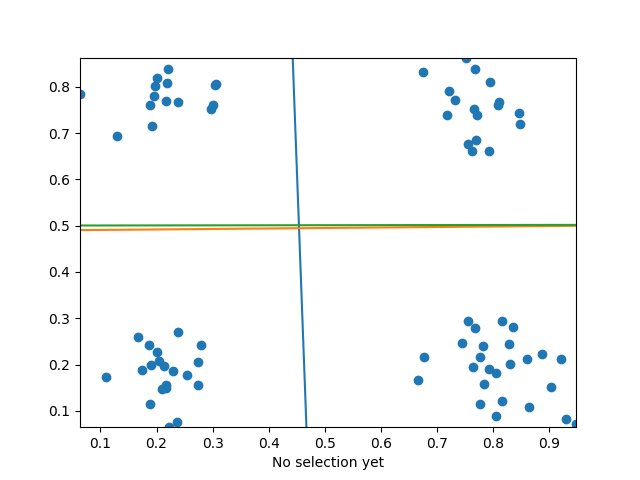

In [59]:
# run for data 1
X_train, Y_train, X_test, Y_test = getData('./data/Data1Train.csv', './data/Data1Test.csv')
class_pairs = [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
#class_pairs = [(1, 2), (1, 3), (2, 3)]
classes = Y_train['Class'].unique()
root_one = Node(None)
curr = root_one

build_tree(curr, classes, X_train, Y_train, True)

minX0D = X_test['x'].min()
maxX0D = X_test['x'].max()
minX1D = X_test['y'].min()
maxX1D = X_test['y'].max()
model_list = []
get_models(root_one, model_list)
fig, ax = plt.subplots()
text=plt.xlabel("No selection yet")

plot_dataset()
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# accuracy for data 1
merge_test_one = X_test.join(Y_test)
count = 0
total = len(merge_test_one['x'])
for x, y, val in zip(merge_test_one['x'], merge_test_one['y'], merge_test_one['Class']):
    model_classify = classify_point(root_one, x, y, True)
    if model_classify == val:
        count += 1
acc = count / total
print("Accuracy of the tree for dataset 1 is " + str(acc))

Accuracy of the tree for dataset 2 is 1.0


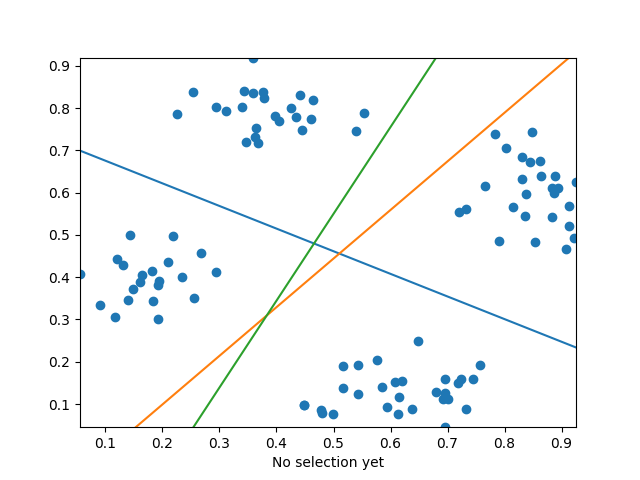

In [60]:
# run for data 2
X_train, Y_train, X_test, Y_test = getData('./data/Data2Train.csv', './data/Data2Test.csv')
class_pairs = [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
#class_pairs = [(1, 2), (1, 3), (2, 3)]
classes = Y_train['Class'].unique()
root_one = Node(None)
curr = root_one

build_tree(curr, classes, X_train, Y_train, True)

minX0D = X_test['x'].min()
maxX0D = X_test['x'].max()
minX1D = X_test['y'].min()
maxX1D = X_test['y'].max()
model_list = []
get_models(root_one, model_list)
fig, ax = plt.subplots()
text=plt.xlabel("No selection yet")

plot_dataset()
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# accuracy for data 2
merge_test_one = X_test.join(Y_test)
count = 0
total = len(merge_test_one['x'])
for x, y, val in zip(merge_test_one['x'], merge_test_one['y'], merge_test_one['Class']):
    model_classify = classify_point(root_one, x, y, True)
    if model_classify == val:
        count += 1
acc = count / total
print("Accuracy of the tree for dataset 2 is " + str(acc))

Accuracy of the tree for dataset 3 is 0.8333333333333334


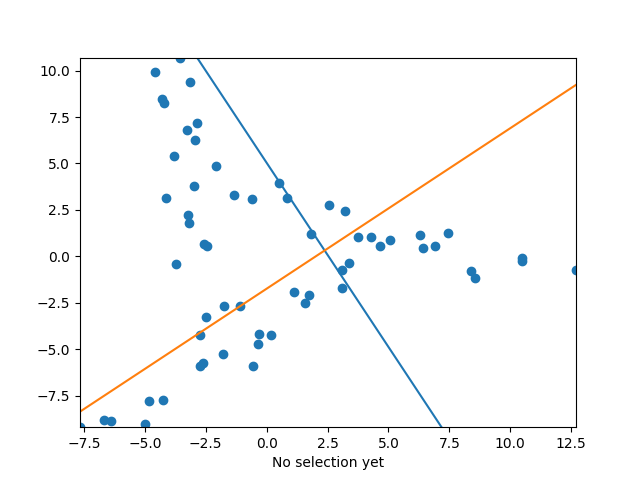

In [61]:
# run for data 3
X_train, Y_train, X_test, Y_test = getData('./data/Data3Train.csv', './data/Data3Test.csv')
class_pairs = [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
classes = Y_train['Class'].unique()
root_one = Node(None)
curr = root_one

build_tree(curr, classes, X_train, Y_train, True)

minX0D = X_test['x'].min()
maxX0D = X_test['x'].max()
minX1D = X_test['y'].min()
maxX1D = X_test['y'].max()
model_list = []
get_models(root_one, model_list)
fig, ax = plt.subplots()
text=plt.xlabel("No selection yet")

plot_dataset()
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# accuracy for data 2
merge_test_one = X_test.join(Y_test)
count = 0
total = len(merge_test_one['x'])
for x, y, val in zip(merge_test_one['x'], merge_test_one['y'], merge_test_one['Class']):
    model_classify = classify_point(root_one, x, y, True)
    if model_classify == val:
        count += 1
acc = count / total
print("Accuracy of the tree for dataset 3 is " + str(acc))

Root 4 has an accuracy of 0.9895833333333334


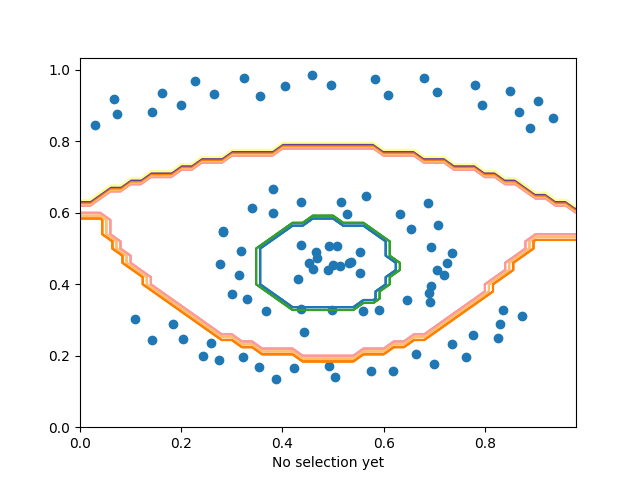

In [64]:
# build tree for dataset 4
X_train, Y_train, X_test, Y_test = getData('./data/Data4Train.csv', './data/Data4Test.csv')
class_pairs = [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
classes = Y_train['Class'].unique()
root_four = Node(None)
curr = root_four

build_tree(curr, classes, X_train, Y_train, False)

print('Root 4 has an accuracy of ' + str(score_accuracy(root_four, X_test, Y_test, False)))

x_min = X_test['x'].min()
x_max = X_test['x'].max()
y_min = X_test['y'].min()
y_max = X_test['y'].max()

fig, ax = plt.subplots()
text=plt.xlabel("No selection yet")

def onclick(event):
    if event.inaxes is not None:
        tx = 'xdata=%f, ydata=%f' % (event.xdata, event.ydata)
        classified = classify_point(root_four, event.xdata, event.ydata, False)
        tx = tx + ' Class ' + str(classified) + ' is selected'

        plt.cla()
        plt.scatter(X_test['x'], X_test['y'], marker='o')

        root_four.model.fit(X_train, Y_train)

        h = .02  # step size in the mesh
        # create a mesh to plot in
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))  

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        Z = root_four.model.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, cmap=plt.cm.Paired)  
        plt.scatter([event.xdata],[event.ydata],c='r')

        text.set_text(tx)
        fig.canvas.draw()
    else:
        print('Clicked outside of an axis.')

cid = fig.canvas.mpl_connect('button_press_event', onclick)

model_list = [root_four, root_four.Left, root_four.Right]

for node_model in model_list:
    node_model.model.fit(X_train, Y_train)

    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = node_model.model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
plt.scatter(X_test['x'], X_test['y'])
plt.show()
